# PRÁCTICA 3.2: Algoritmo bagging y gradient boosting

### Rubén Martínez Gijón y Jon Zorrilla Gamboa

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import time

#### Funciones auxiliares
Definición de conjuntos de datos en 2D para el análisis visual de las fronteras de decisión y cómo cambian con algunos parámetros. Funciones (inspiradas en sklearn) que usaremos a lo largo del notebook. 

La primera, *createDataSet*, es para crear los problemas, siempre de dos clases y en dos dimensiones. Sus argumentos son:

- *n*, número de patrones en el problema

- *model*, tipo de modelo para la frontera que separa las clases, puede ser 'linear', 'square' o 'sine'

- *ymargin*, margen de separación entre las dos clases, cuanto mayor es *ymargin* más separadas están las clases, valores negativos implican solape entre las clases

- *noise*, introduce un ruido gausiano a la x e y

- *output_boundary*, Si vale True la función devuelve la frontera de decisión

In [2]:
def createDataSet(n,model,ymargin,noise=None,output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return x, y, (c*1).ravel(), xbnd, ybnd
    else:
        return x, y, (c*1).ravel()

La función *plotModel* la usaremos para dibujar el resultado de un clasificador sobre el conjunto de datos. Sus argumentos son:

- *x*, coordenada x de los puntos

- *y*, coordenada y de los puntos

- *c*, clase de los puntos, si se pasa None, entonces considera que x e y son la frontera real de decisión y la muestra con plot

- *clf*, el clasificador

- *title*, título para el gráfico

In [3]:
def plotModel(x,y,clase,clf,title=""):
    from matplotlib.colors import ListedColormap
    
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    if hasattr(clf, "decision_function"):
        z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    elif hasattr(clf, "predict_proba"):
        z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    z = z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [0.5], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter(x[clase==0], y[clase==0], c='#FF0000')
        plt.scatter(x[clase==1], y[clase==1], c='#0000FF')
    else:
        plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

La función, *plotData*, la usaremos para dibujar los datos. Sus argumentos son:

- *x*, coordenada x de los puntos

- *y*, coordenada y de los puntos

- *c*, clase de los puntos

- *style0*, estilo con el que pintamos los puntos de la clase 0

- *style1*, estilo con el que pintamos los puntos de la clase 1

- *title*, título para el gráfico

In [4]:
def plotData(x,y,c,style0,style1,title=''):
    plt.scatter(x[c==0],y[c==0],**style0)
    plt.scatter(x[c==1],y[c==1],**style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

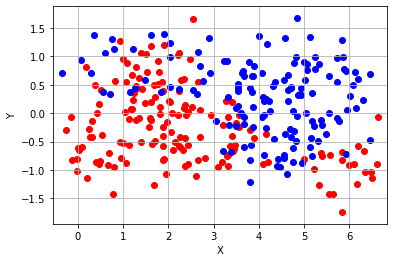

In [5]:
# Problem data:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.3             # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)

x1, x2, ytrain, xbnd, ybnd = createDataSet(n, model, ymargin, noise, True)
Xtrain = np.concatenate((x1, x2), axis = 1)

x1test, x2test, ytest      = createDataSet(n*10, model, ymargin, noise)
Xtest = np.concatenate((x1test, x2test), axis = 1)

plotData(x1,x2,ytrain,{'c':'#FF0000'},{'c':'#0000FF'})


### Parte 1: Algoritmo Bagging

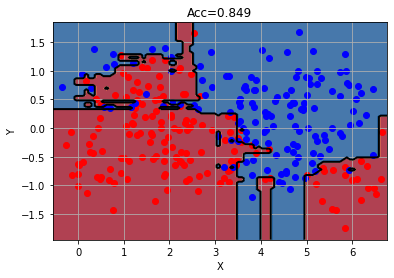

In [6]:
from sklearn.tree import DecisionTreeClassifier
import scipy as sp

class BaggingCasero:
    def __init__(self, n_estimators=101):
        self.n_estimators = n_estimators
        self._estimators = []
    
    def fit(self,X,y):
        N = X.shape[0]
        
        for i in range(self.n_estimators):
            """
              Rellenar esta parte para que cree un árbol usando
              una muestra bootstrap de los datos
            """
            n_sample = np.random.randint(0, N, N)
            X_train = X[n_sample]
            y_train = y[n_sample]
            tree = DecisionTreeClassifier()
            tree.fit(X_train, y_train)
            
            self._estimators.append(tree)
            
    def predict(self,X):
        votos = np.zeros((X.shape[0],len(self._estimators)))
        # Calcula la salida de cada árbol para cada dato
        for ie,estimator in enumerate(self._estimators):
            votos[:,ie] = estimator.predict(X)
            
        """
           Calcula la clase más votada de cada ejemplo, es decir,
           la moda
        """
        
        return sp.stats.mode(votos, axis = 1).mode.ravel()
                    
bagging = BaggingCasero()
bagging.fit(Xtrain, ytrain)
acc = np.sum(bagging.predict(Xtest)==ytest)/len(ytest)
plotModel(x1,x2,ytrain,bagging,"Acc="+str(acc))

### Parte 2: Algoritmo gradient boosting
Algoritmo de gradient boosting para implementar. Solo hay que incluir el código en las partes indicadas. Se implementará el algoritmo para regresión y para clasificación

In [7]:
from sklearn.tree import DecisionTreeRegressor

""" Solo se va a implementar para regresión y para clasificación 
    binaria con clases igual a -1 y +1
"""

class SquaredErrorLoss: #Regresion
    """ Clase que define elementos para la función cuadrática de perdida 
        para regresión """
    
    def F0(_, X, y):
        """ Calcula el valor constante que minimiza la salida 'y' """
        return np.mean(y)

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return y - F

    def paso_newton_hoja(_, y, residuos, valor):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado alarbol regresor ht
           Además recine el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """
        return valor #Los multiplicadores son 1
    
    def predict(_, y):
        return y

    def __call__(self, y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return 0.5 * (y - F) ** 2

    
class LogLoss: #Clasificacion
    """ Clase que define elementos para la función logística de perdida 
        para clasificación de dos clases {-1, +1} """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        ybar = np.mean(y)
        return 0.5 * np.log((1.0 + ybar)/(1.0 - ybar))

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return 2.0 * y / (1 + np.exp(2.0 * y * F))

    def paso_newton_hoja(_, y, residuos, valor):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado alarbol regresor ht
           Además recine el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """
        numerador = np.sum(residuos)
        denominador = np.sum((np.abs(residuos)) * (2.0 - np.abs(residuos)))

        if np.abs(denominador) < 1e-20:
            return 0.0

        return numerador / denominador

    def predict(self, y):
        return 2*((1.0/(1.0 + np.exp(-2 * y))) >= 0.5) - 1
    
    def __call__(self, y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return np.log(1 + np.exp(-2.0 * y * F))
     
class GBCasero:
    def __init__(self, n_estimators=101, loss=SquaredErrorLoss(), eta=0.1, depth=3):
        self.n_estimators = n_estimators
        self._estimators  = []
        self.depth        = depth
        self.eta          = eta
        # La implementación de loss se usará en fit para crear el algoritmo
        # GB de forma genérica.
        self.loss         = loss
    
    def fit(self,X,y):
        """
          Inicializa GB 
        """


        for i in range(self.n_estimators):
            """
              Rellenar esta parte para implementar GB 
              Se debe utilizar la función paso_newton de abajo
            """
            tree = DecisionTreeRegressor(max_depth = self.depth)
            residuos = self.loss.residuos(y, self.predict(X))
            tree.fit(X, residuos)
            self.paso_newton_general(tree, X, y, residuos)
            self._estimators.append(tree)
        
            
    def predict(self,X):
        """ Combinamos los valores de pesos y hs para obtener la 'salida' o
             predicciones en crudo, y que haga:
               * Para regresión se devuelve 'salida'
               * Para clasificación de 2 clases se calcula la probabilidad
                  con una sigmoidal (1 / (1 + np.exp(-2*salida))) y se 
                  devuelve la clase más probable 
                  
            Nota1: Podéis delegar esto a las funciones de pérdida para evitar 
                   poner aquí in if
            Nota2: Podéis también organizar la clasificacion/regresion al estilo
                   sklearn e implementar predict_proba en la clasificación.
                
        """
        salida = sum(item.predict(X)*self.eta for item in self._estimators)
        return self.loss.predict(salida)

    def paso_newton_general(self, tree, X, y, residuos):
        """ Esta función actualiza todas las hojas de salida
            del árbol 'tree' utilizado la función paso_newton_hoja
            de las clases de funcion de pérdida """
        TREE_LEAF = -1
        tree = tree.tree_
        leaf_indices = tree.apply(np.array(X,dtype=np.float32))
        for leaf in np.where(tree.children_left == TREE_LEAF)[0]:
            ii = leaf_indices==leaf
            tree.value[leaf,0,0] = self.loss.paso_newton_hoja(y[ii],
                                                              residuos[ii],
                                                              tree.value[leaf,0,0])


Probamos este algoritmo con el conjunto de datos anterior.

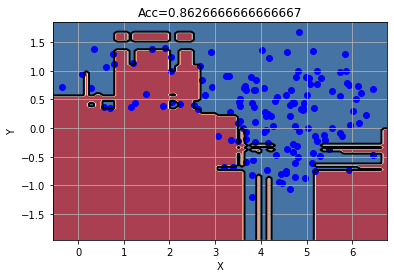

In [8]:
from sklearn.preprocessing import LabelBinarizer

# Basic example
gb = GBCasero(loss=LogLoss())

lb     = LabelBinarizer(pos_label = 1, neg_label = -1)
ytrain = lb.fit_transform(ytrain).ravel()
ytest  = lb.transform(ytest).ravel()

gb.fit(Xtrain, ytrain)
acc = np.sum(gb.predict(Xtest)==ytest)/len(ytest)
plotModel(x1,x2,ytrain,gb,"Acc="+str(acc))

#### Implementación del algoritmo con Magic04

In [9]:
from sklearn.preprocessing import LabelBinarizer

# Magic
fP = 'magic04.csv'
dfP = pd.read_csv(fP, sep=',')

X_tr, X_ts, y_tr, y_ts = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], 
                                          test_size=0.8, random_state=1)
lb   = LabelBinarizer(pos_label = 1, neg_label = -1)
y_tr = lb.fit_transform(y_tr).ravel()
y_ts = lb.transform(y_ts).ravel()

gb = GBCasero(loss=LogLoss())
start_time_1 = time.time()
gb.fit(X_tr, y_tr)

print('GBCasero')
print("- Accuracy in Magic04=",np.sum(gb.predict(X_ts)==y_ts)/len(y_ts))
print("--- %s seconds ---" % (time.time() - start_time_1))

# Gradient boosting de sklearn para comparar la accuracy
print('\nGradientBoostingClassifier')
clf = GradientBoostingClassifier(n_estimators=101, learning_rate=0.1,max_depth=3)
start_time_2 = time.time()
clf.fit(X_tr, y_tr)
acc = clf.score(X_ts, y_ts)
print("- Accuracy in Magic04 =",acc)
print("--- %s seconds ---" % (time.time() - start_time_2))

GBCasero
- Accuracy in Magic04= 0.8500262881177708
--- 12.745827913284302 seconds ---

GradientBoostingClassifier
- Accuracy in Magic04 = 0.86198738170347
--- 1.1569955348968506 seconds ---


Tras la anterior implementación, se puede observar como nuestro algortimo casero es bastante competitivo, ya que tiene una precisión del 85.0% muy cercana de la del algoritmo de Sklearn 86.2%. Por otro lado, también podemos observar que el tiempo de ejecución de nuestro algoritmo es bastante superior al tiempo que tarda GradientBoostingClassifier.